# Plan

## 1. Cleaning and pre-process

### 1a. Drop non relevant columns and drop rows with less than 5% entries

### 1b. Split dataset in houses and apartments, delete outliers

### 1c. Impute missing values for each group

### 1d. Merge dataset back and feature engineering (Ordinal encoding for state of the building, one hot encoding for apartment type )


In [30]:
%pip install torch

Note: you may need to restart the kernel to use updated packages.


In [31]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder,StandardScaler,RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer,SimpleImputer
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim


In [32]:
df = pd.DataFrame(pd.read_csv('immoweb_data_cleaned.csv'))
df_dummies = pd.get_dummies(df["Type_of_Property"])
df_dummies = pd.concat([df,df_dummies], axis=1)
df_dummies.drop('Type_of_Property', axis=1,inplace=True)
df_dummies.drop('Subtype_of_Property', axis=1,inplace=True)



In [33]:
df_dummies.isna().sum().sort_values(ascending=False)

Price                        0
Locality                     0
State_of_the_Building        0
Number_of_Rooms              0
Living_Area                  0
Fully_Equipped_Kitchen       0
Terrace                      0
Garden                       0
Surface_area_plot_of_land    0
Number_of_Facades            0
Swimming_Pool                0
Lift                         0
Municipality                 0
Province                     0
APARTMENT                    0
HOUSE                        0
dtype: int64

In [34]:
import missingno as msno

In [35]:
apartments = df_dummies[df_dummies["APARTMENT"] == 1]
houses = df_dummies[df_dummies["HOUSE"] == 1]

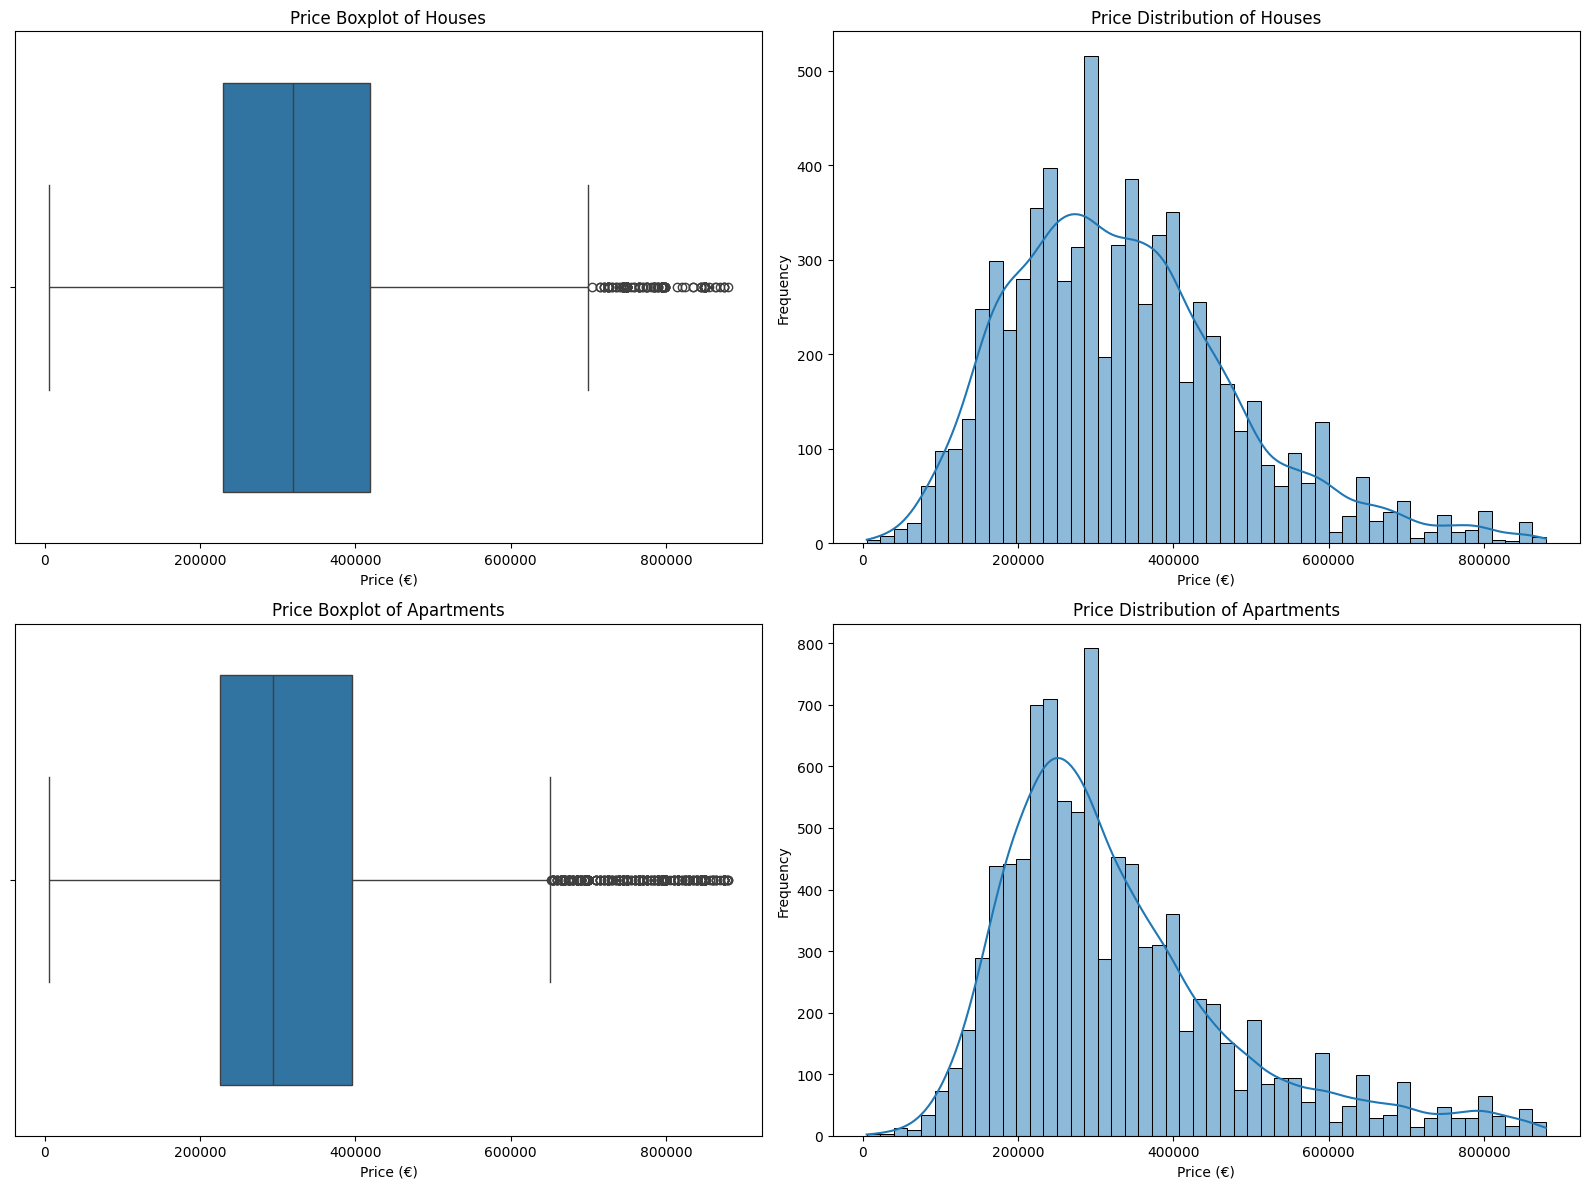

0.0
9581
0.0
7050
Price                        0
Locality                     0
State_of_the_Building        0
Number_of_Rooms              0
Living_Area                  0
Fully_Equipped_Kitchen       0
Terrace                      0
Garden                       0
Surface_area_plot_of_land    0
Number_of_Facades            0
Swimming_Pool                0
Lift                         0
Municipality                 0
Province                     0
APARTMENT                    0
HOUSE                        0
dtype: int64
Price                        0
Locality                     0
State_of_the_Building        0
Number_of_Rooms              0
Living_Area                  0
Fully_Equipped_Kitchen       0
Terrace                      0
Garden                       0
Surface_area_plot_of_land    0
Number_of_Facades            0
Swimming_Pool                0
Lift                         0
Municipality                 0
Province                     0
APARTMENT                    0
HOUSE   

In [36]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
# 1. Boxplot for Houses
sns.boxplot(x='Price', data=houses, ax=axes[0, 0])
axes[0, 0].set_xlabel('Price (€)')
axes[0, 0].set_title('Price Boxplot of Houses')

# 2. Histogram for Houses
sns.histplot(houses['Price'], bins=50, kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Price Distribution of Houses')
axes[0, 1].set_xlabel('Price (€)')
axes[0, 1].set_ylabel('Frequency')

# 3. Boxplot for Apartments
sns.boxplot(x='Price', data=apartments, ax=axes[1, 0])
axes[1, 0].set_xlabel('Price (€)')
axes[1, 0].set_title('Price Boxplot of Apartments')

# 4. Histogram for Apartments
sns.histplot(apartments['Price'], bins=50, kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Price Distribution of Apartments')
axes[1, 1].set_xlabel('Price (€)')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

print(apartments[apartments['Price'] > 1000000].shape[0] / apartments.shape[0] * 100)
print(apartments.shape[0])
print(houses[houses['Price'] > 1000000].shape[0] /houses.shape[0] * 100 )
print(houses.shape[0])

high_priced_apartments = apartments[apartments['Price'] > 1_000_000]

print(houses.isna().sum().sort_values(ascending=False))
print(apartments.isna().sum().sort_values(ascending=False))


In [37]:
#Encode categorical values for state_of_the_building
states = ['TO_RENOVATE','TO_BE_DONE_UP','TO_RESTORE','GOOD','JUST_RENOVATED','AS_NEW']
ordinal_encoder = OrdinalEncoder(categories=[states])
#For houses
state_h = houses['State_of_the_Building']
state_not_null_h = state_h[state_h.notnull()].values.reshape(-1,1)
state_h_encoded = ordinal_encoder.fit_transform(state_not_null_h)
houses.loc[state_h.notnull(), 'State_of_the_Building'] = np.squeeze(state_h_encoded)
#For apartments
state_a = apartments['State_of_the_Building']
state_not_null_a = state_a[state_a.notnull()].values.reshape(-1,1)
state_a_encoded = ordinal_encoder.fit_transform(state_not_null_a)
apartments.loc[apartments["State_of_the_Building"].notnull(), 'State_of_the_Building'] = np.squeeze(state_a_encoded)

In [38]:
houses.drop(['Municipality','Province'], axis=1,inplace=True)
houses.head()

/var/folders/z6/vnwrtwgd7x5chl_2vn910h6r0000gn/T/ipykernel_2020/1943697176.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  houses.drop(['Municipality','Province'], axis=1,inplace=True)


,Price,Locality,State_of_the_Building,Number_of_Rooms,Living_Area,Fully_Equipped_Kitchen,Terrace,Garden,Surface_area_plot_of_land,Number_of_Facades,Swimming_Pool,Lift,APARTMENT,HOUSE
2,259000,5030,3.0,3,154.0,0,0.0,1.0,200.0,3.0,0.0,0.0,False,True
5,229000,2500,3.0,2,105.0,0,0.0,0.0,43.0,3.0,0.0,0.0,False,True
6,260000,9620,3.0,3,219.0,0,0.0,0.0,375.0,3.0,0.0,0.0,False,True
8,340000,2150,0.0,4,270.0,0,0.0,0.0,156.0,2.0,0.0,0.0,False,True
10,315000,9100,1.0,4,145.0,0,0.0,0.0,401.0,4.0,0.0,0.0,False,True


/var/folders/z6/vnwrtwgd7x5chl_2vn910h6r0000gn/T/ipykernel_2020/3584389490.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  houses[col] = houses[col].astype('float32')
/var/folders/z6/vnwrtwgd7x5chl_2vn910h6r0000gn/T/ipykernel_2020/3584389490.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  houses[col] = houses[col].astype('float32')
/var/folders/z6/vnwrtwgd7x5chl_2vn910h6r0000gn/T/ipykernel_2020/3584389490.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

<Axes: >

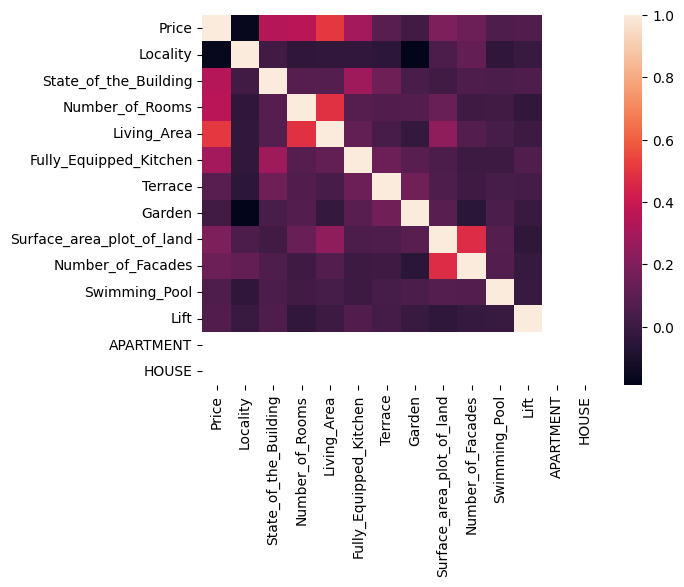

In [39]:
for col in houses.columns:
    houses[col] = houses[col].astype('float32')

sns.heatmap(houses.corr())

In [40]:
# mode_imputer = SimpleImputer(strategy='most_frequent')

# state_encoded = houses['state_of_building'].values.reshape(-1, 1)

# state_imputed = mode_imputer.fit_transform(state_encoded)

# houses['state_of_building'] = state_imputed.squeeze()


<Axes: >

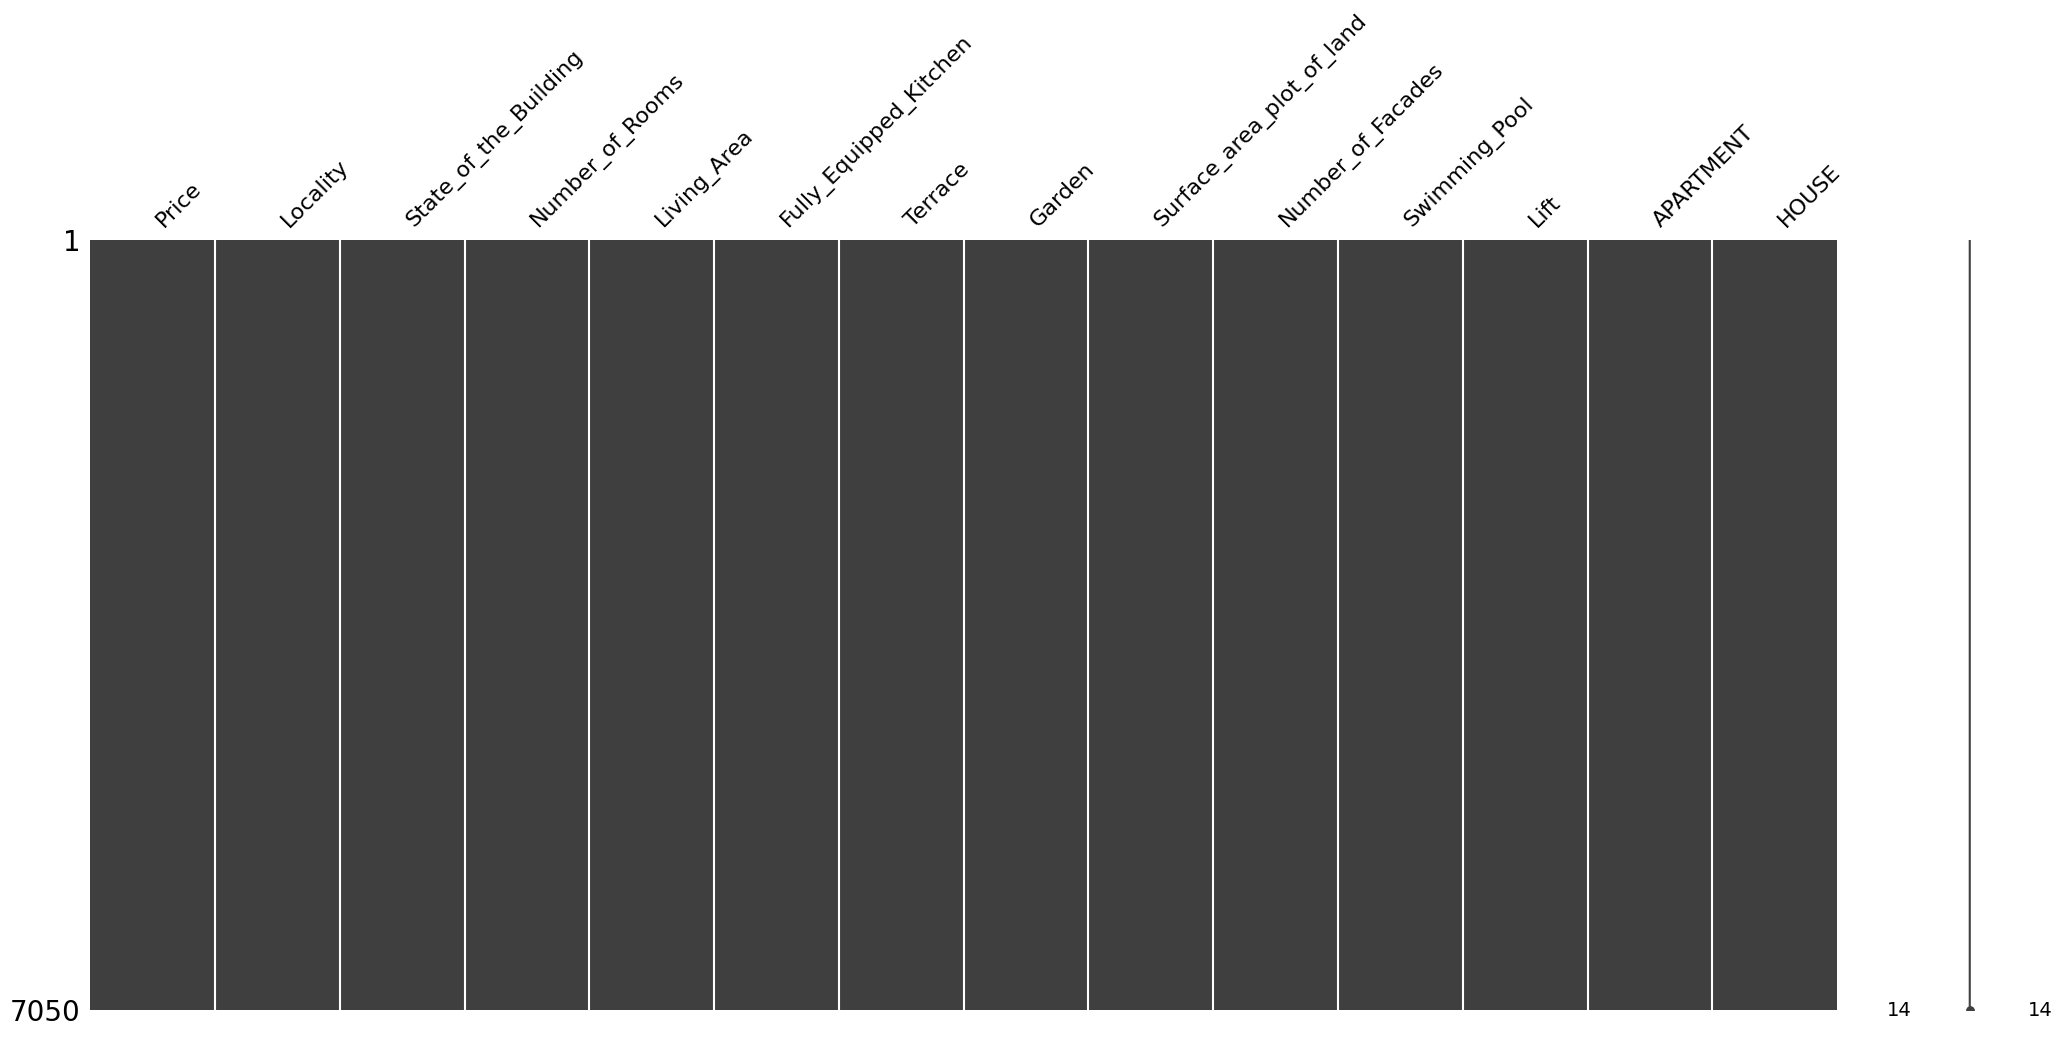

In [41]:
msno.matrix(houses)

In [42]:
houses.dropna(subset=['latitude','longitude',''], inplace=True)
houses.isnull().sum().sort_values(ascending=False)

KeyError: ['latitude', 'longitude', '']

In [ ]:
houses.living_area.min()

np.float64(19.0)

In [ ]:
# from sklearn.metrics import root_mean_squared_error


# numerical_features = ['surface_of_the_plot', 'nb_facades','living_area']
# categorical_feature = ['state_of_building']
# target = 'Price'  

# X_h = houses.drop(target, axis=1)
# y_h = houses[target]

# X_train_h, X_test_h, y_train_h, y_test_h = train_test_split(
#     X_h, y_h, test_size=0.2, random_state=42
# )

# num_imputer = SimpleImputer(strategy='mean')
# mode_imputer = SimpleImputer(strategy='most_frequent')
# X_train_h_num = num_imputer.fit_transform(X_train_h[numerical_features])
# X_test_h_num = num_imputer.transform(X_test_h[numerical_features])

# X_train_h.loc[:, numerical_features] = X_train_h_num
# X_test_h.loc[:, numerical_features] = X_test_h_num

# X_train_h_cat = mode_imputer.fit_transform(X_train_h[categorical_feature].values.reshape(-1, 1))
# X_test_h_cat = mode_imputer.transform(X_test_h[categorical_feature].values.reshape(-1, 1))

# # Assign imputed categorical values back to DataFrame
# X_train_h[categorical_feature] = X_train_h_cat
# X_test_h[categorical_feature] = X_test_h_cat

# scaler = RobustScaler()
# X_train_h[numerical_features] = scaler.fit_transform(X_train_h[numerical_features])
# X_test_h[numerical_features] = scaler.transform(X_test_h[numerical_features])

# # model = LinearRegression()
# # model.fit(X_train_h, y_train_h)

# print(X_train_h)




KeyError: "None of [Index(['surface_of_the_plot', 'nb_facades', 'living_area'], dtype='object')] are in the [columns]"

In [ ]:
# from torch.utils.data import TensorDataset,DataLoader,Dataset

# class Data(Dataset):
#     def __init__(self, X, y):
#         self.X = torch.from_numpy(X.values.astype(np.float32))
#         self.y = torch.from_numpy(y.values.astype(np.float32))
#         self.len = self.X.shape[0]
       
#     def __getitem__(self, index):
#         return self.X[index], self.y[index]
   
#     def __len__(self):
#         return self.len

# train_data = Data(X_train_h,y_train_h)
# train_dataloader = DataLoader(dataset=train_data, batch_size=64, shuffle=True)
# test_data = Data(X_test_h, y_test_h)
# test_dataloader = DataLoader(dataset=test_data, batch_size=64, shuffle=True)
# for batch, (X, y) in enumerate(train_dataloader):
#     print(f"Batch: {batch+1}")
#     print(f"X shape: {X}")
#     print(f"y shape: {y.shape}")
#     break

# class LinearRegressionModel(nn.Module):
#     def __init__(self, in_features, out_features):
#         super().__init__()
#         self.linear = nn.Linear(in_feature, out_features)
    

In [ ]:
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [64]:
from tensorflow.keras.layers import Dense,Normalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD,Adam


In [61]:
def get_new_model(input_shape):    
    model = Sequential()
    model.add(Dense(100,activation='relu', input_shape=(input_shape,)))
    model.add(Dense(100,activation='relu'))
    model.add(Dense(100,activation='relu'))
    model.add(Dense(1))
    return model

In [43]:
houses.head(10)

,Price,Locality,State_of_the_Building,Number_of_Rooms,Living_Area,Fully_Equipped_Kitchen,Terrace,Garden,Surface_area_plot_of_land,Number_of_Facades,Swimming_Pool,Lift,APARTMENT,HOUSE
2,259000.0,5030.0,3.0,3.0,154.0,0.0,0.0,1.0,200.0,3.0,0.0,0.0,0.0,1.0
5,229000.0,2500.0,3.0,2.0,105.0,0.0,0.0,0.0,43.0,3.0,0.0,0.0,0.0,1.0
6,260000.0,9620.0,3.0,3.0,219.0,0.0,0.0,0.0,375.0,3.0,0.0,0.0,0.0,1.0
8,340000.0,2150.0,0.0,4.0,270.0,0.0,0.0,0.0,156.0,2.0,0.0,0.0,0.0,1.0
10,315000.0,9100.0,1.0,4.0,145.0,0.0,0.0,0.0,401.0,4.0,0.0,0.0,0.0,1.0
12,560000.0,9000.0,3.0,4.0,152.0,0.0,1.0,0.0,175.0,3.0,0.0,1.0,0.0,1.0
16,383011.0,9800.0,5.0,3.0,148.0,0.0,0.0,0.0,313.0,3.0,0.0,0.0,0.0,1.0
19,525000.0,9000.0,5.0,4.0,198.0,0.0,1.0,0.0,79.0,2.0,0.0,0.0,0.0,1.0
25,295000.0,8000.0,3.0,2.0,90.0,0.0,1.0,0.0,55.0,3.0,0.0,0.0,0.0,1.0
30,315000.0,9600.0,3.0,3.0,195.0,0.0,1.0,1.0,393.0,3.0,0.0,0.0,0.0,1.0


In [70]:
target = 'Price'  
numerical_features = ['Surface_area_plot_of_land','Living_Area']

X_h = houses.drop(target, axis=1)
y_h = houses[target]
X_train_h, X_test_h, y_train_h, y_test_h = train_test_split(
    X_h, y_h, test_size=0.2, random_state=42
)

for col in numerical_features:
    
    # fit on training data column
    scale = RobustScaler().fit(X_train_h[col].values.reshape(-1,1))
    
    # transform the training data column
    X_train_h[col] = scale.transform(X_train_h[col].values.reshape(-1,1))
    
    # transform the testing data column
    X_test_h[col] = scale.transform(X_test_h[col].values.reshape(-1,1))
# X_train_h[numerical_features] = scaler.fit_transform(X_train_h[numerical_features])
# X_test_h[numerical_features] = scaler.transform(X_test_h[numerical_features])

In [ ]:
n_cols = len(X_train_h.columns)
early_stopping_monitor = EarlyStopping(patience=10)
lr_to_test = np.linspace(0.00000001,0.1,10)
print(lr_to_test)
for lr in lr_to_test:
    model = get_new_model(n_cols)
    model.compile(optimizer =Adam(learning_rate=lr), loss ='mean_squared_error',metrics=['accuracy'])
    model.fit(X_train_h,y_train_h,validation_split=0.3,epochs=200,callbacks=[early_stopping_monitor])


[1.000000e-08 1.111112e-02 2.222223e-02 3.333334e-02 4.444445e-02
 5.555556e-02 6.666667e-02 7.777778e-02 8.888889e-02 1.000000e-01]
Epoch 1/200


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0000e+00 - loss: 130754297856.0000 - val_accuracy: 0.0000e+00 - val_loss: 134482116608.0000
Epoch 2/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step - accuracy: 0.0000e+00 - loss: 135132807168.0000 - val_accuracy: 0.0000e+00 - val_loss: 134481952768.0000
Epoch 3/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step - accuracy: 0.0000e+00 - loss: 134611992576.0000 - val_accuracy: 0.0000e+00 - val_loss: 134481764352.0000
Epoch 4/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step - accuracy: 0.0000e+00 - loss: 130506850304.0000 - val_accuracy: 0.0000e+00 - val_loss: 134481518592.0000
Epoch 5/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step - accuracy: 0.0000e+00 - loss: 133022818304.0000 - val_accuracy: 0.0000e+00 - val_loss: 134481338368.0000
Epoch 6/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step - accuracy: 0.0000e+00 - loss: 130444197888.0000 - val_accuracy: 0.0000e+00 - val_loss: 134481125376.0000
Epoch 7/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 966u

tensor(1.8310e+11, grad_fn=<MseLossBackward0>)
tensor(6.2173e+31, grad_fn=<MseLossBackward0>)
tensor(nan, grad_fn=<MseLossBackward0>)
tensor(nan, grad_fn=<MseLossBackward0>)
tensor(nan, grad_fn=<MseLossBackward0>)
tensor(nan, grad_fn=<MseLossBackward0>)
tensor(nan, grad_fn=<MseLossBackward0>)
tensor(nan, grad_fn=<MseLossBackward0>)
tensor(nan, grad_fn=<MseLossBackward0>)
tensor(nan, grad_fn=<MseLossBackward0>)
tensor(nan, grad_fn=<MseLossBackward0>)
tensor(nan, grad_fn=<MseLossBackward0>)
tensor(nan, grad_fn=<MseLossBackward0>)
tensor(nan, grad_fn=<MseLossBackward0>)
tensor(nan, grad_fn=<MseLossBackward0>)
tensor(nan, grad_fn=<MseLossBackward0>)
tensor(nan, grad_fn=<MseLossBackward0>)
tensor(nan, grad_fn=<MseLossBackward0>)
tensor(nan, grad_fn=<MseLossBackward0>)
tensor(nan, grad_fn=<MseLossBackward0>)
tensor(nan, grad_fn=<MseLossBackward0>)
tensor(nan, grad_fn=<MseLossBackward0>)
tensor(nan, grad_fn=<MseLossBackward0>)
tensor(nan, grad_fn=<MseLossBackward0>)
tensor(nan, grad_fn=<MseLo

In [ ]:
from sklearn.metrics import r2_score  # Import R-squared metric

y_pred = model.predict(X_test_h)
r2 = r2_score(y_test_h, y_pred)
print(f'R-squared (using r2_score): {r2:.4f}')

AttributeError: 'Sequential' object has no attribute 'predict'